In [15]:
from matplotlib import pyplot as plt
import torch
import numpy as np
from scipy import stats
import math
from typing import List, Tuple, Any
import sqlite3
import os
import pandas as pd

In [18]:
def plot_tests_vs(tests_acromym, value, focus_dict = None, table_name="results"):
    """
    Creates the image of a grid of the global/local transformation between dstributions
    """
    plt.figure(figsize=(10,6))

    #creating the grid for the plot
    size = len(tests_acromym)
    grid = np.zeros((size, size))

    for i, global_name in enumerate(tests_acromym):
        for j, local_name in enumerate(tests_acromym):
            database_path = os.path.join("Databases", f"database_{global_name}2{local_name}.db")

            try:
                # Use context manager for database connection
                with sqlite3.connect(database_path) as conn:
                    
                    if focus_dict is None: # If focus = None then we consider all the available values
                        cursor = conn.cursor()

                        # Fetching all the values from the table
                        query = f"SELECT {value} FROM {table_name}"
                        cursor.execute(query)
                    
                        results = cursor.fetchall()

                        # Convert results to numpy arrays
                        x_list = []
                        for row in results:
                            if (row[0] is not None):
                                x_list.append(float(row[0]))
                            else:
                                print("one None found")
                        x_array = np.array(x_list)

                    else:
                        df = pd.read_sql("table_name", conn)
                        mask = pd.Series(True, index=df.index)
                        
                        for column, values in focus_dict.items():
                            mask &= df[column].isin(values)
                        
                        # Obtaining all the values that follow the focus requirement
                        values_list = df[mask]['value'].tolist()

                        x_list = []
                        for x in values_list:
                            if x is not None:
                                x_list.append(x)
                            else:
                                print("one None found")

                        # Converting into the numpy array
                        x_array = np.array(x_list)

                grid[i][j] = np.average(x_array)

            except sqlite3.Error as e:
                print(f"Database error: {e}")
            except Exception as e:
                print(f"Error: {e}")

    # Plot the grid with proper configuration
    plt.figure(figsize=(10, 6))
    im = plt.imshow(grid, cmap='viridis', aspect='equal')
    
    # Add colorbar
    plt.colorbar(im, label=value)
    
    # Add labels and ticks
    plt.xticks(range(size), tests_acromym, rotation=45)
    plt.yticks(range(size), tests_acromym)
    
    # Add labels for axes
    plt.xlabel('Local Distribution')
    plt.ylabel('Global Distribution')
    
    # Add title
    plt.title(f'Local Trasformation - {value}')
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    print(grid)
                
            



def plot_database_columns(test_names, x_column, y_column, table_name="results", z_column=None, focus=None):
    """
    Create a scatter plot from two columns in a SQLite database table.
    
    Parameters:
    test_names (list): List of names of the tests to be plotted
    x_column (str): Name of the column to plot on x-axis
    y_column (str): Name of the column to plot on y-axis
    table_name (str): Name of the table in the database
    z_column (str, optional): Name of column to filter on
    focus (list, optional): List of values to filter z_column by
    """

    # Create figure once, outside the loop
    plt.figure(figsize=(8, 4))
    # Create a list of colors for different tests
    colors = ['b', 'r', 'g', 'c', 'm', 'y', 'k']
    # Store statistics for all tests
    stats_summary = {}

    for idx, test_name in enumerate(test_names):

        # Select the right database and color for the plotting
        color = colors[idx % len(colors)]  # Cycle through colors if more tests than colors
        database_path = os.path.join("Databases", f"database_{test_name}.db")

        try:
            # Use context manager for database connection
            with sqlite3.connect(database_path) as conn:
                cursor = conn.cursor()
                
                # Create a query to select the desired columns with optional filtering
                if z_column and focus:
                    # Convert the focus list to string for SQL IN clause
                    focus_str = ', '.join('?' * len(focus))
                    # No need for separate column selection if column_z is x_column or y_column
                    query = f"""
                        SELECT DISTINCT {x_column}, {y_column}
                        FROM {table_name}
                        WHERE {z_column} IN ({focus_str})
                    """
                    # Execute with parameters
                    cursor.execute(query, focus)
                else:
                    query = f"SELECT {x_column}, {y_column} FROM {table_name}"
                    cursor.execute(query)
                
                results = cursor.fetchall()
                
                if not results:
                    print("No data found matching the specified criteria.")
                    return
            
            # Convert results directly to numpy arrays
            #x_array = np.array([float(row[0]) for row in results])
            #y_array = np.array([float(row[1]) for row in results])

            # Convert results to numpy arrays
            x_list = []
            y_list = []
            for row in results:
                if (row[0] is not None) and (row[1] is not None):
                    x_list.append(float(row[0]))
                    y_list.append(float(row[1]))
                else:
                    print("one None found")
            x_array = np.array(x_list)
            y_array = np.array(y_list)
            
            # Calculate regression line
            slope, intercept, r_value, p_value, std_err = stats.linregress(x_array, y_array)
            
            # Create points for regression line
            line_x = np.array([x_array.min(), x_array.max()]).reshape(-1, 1)
            line_y = slope * line_x + intercept

            # Store statistics
            stats_summary[test_name] = {
                'slope': slope,
                'intercept': intercept,
                'r_squared': r_value**2,
                'p_value': p_value,
                'std_err': std_err
            }
            #print(f'Regression line\ny = {slope:.4f}x + {intercept:.4f}\nR² = {r_value**2:.4f}\np value = {p_value}\nstd_error = {std_err}')
            
            # Create the scatter plot
            plt.scatter(x_array, y_array, alpha=0.3, color=color, s=5)
            
            # Plot regression line
            plt.plot(line_x, line_y, linestyle='-', label=f"{test_name}", color=color)
                    #label=f'Regression line\ny = {slope:.4f}x + {intercept:.4f}\nR² = {r_value**2:.4f}\np value = {p_value}\nstd_error = {std_err}')            
            
        except sqlite3.Error as e:
            print(f"Database error: {e}")
        except Exception as e:
            print(f"Error: {e}")

   # Customize the plot (only once, after all tests are plotted)
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    title = f'{y_column} vs {x_column}'
    if z_column and focus:
        title += f'\n(filtered {z_column} in {focus})'
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    # Print detailed statistics
    print("\nRegression Statistics:")
    print("-" * 50)
    for test_name, stats_dict in stats_summary.items():
        print(f"\n{test_name}:")
        print(f"Equation: y = {stats_dict['slope']:.4f}x + {stats_dict['intercept']:.4f}")
        print(f"R² = {stats_dict['r_squared']:.4f}")
        print(f"p-value = {stats_dict['p_value']:.4e}")
        print(f"Standard Error = {stats_dict['std_err']:.4f}")

    # Show the plot (only once, after everything is done)
    plt.show()


Regression Statistics:
--------------------------------------------------

New_everything:
Equation: y = 0.0094x + 0.1706
R² = 0.0010
p-value = 8.1869e-01
Standard Error = 0.0407


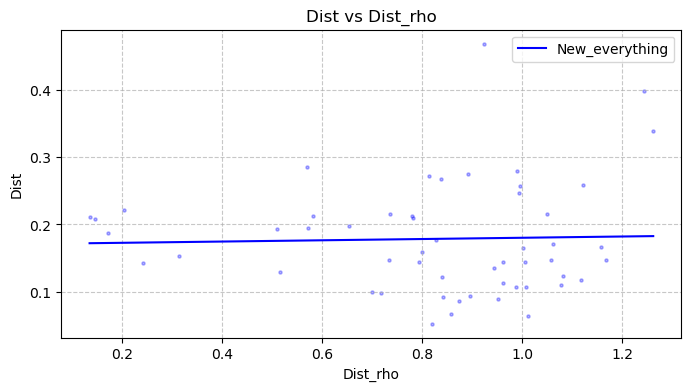

In [4]:
test_name = ["New_everything"]
x_column = "Dist_rho"
y_column = "Dist"
table_name = "results"

z_column = None#"n_traj_points"
focus = None#[11, 50]

plot_database_columns(test_name, x_column, y_column, table_name, z_column=z_column, focus=focus)


Regression Statistics:
--------------------------------------------------

M2E:
Equation: y = -0.0001x + 0.5739
R² = 0.0043
p-value = 5.0084e-01
Standard Error = 0.0001

E2E:
Equation: y = 0.0000x + 0.0555
R² = 0.0072
p-value = 3.8268e-01
Standard Error = 0.0000

B2E:
Equation: y = 0.0001x + 0.3702
R² = 0.0165
p-value = 1.8556e-01
Standard Error = 0.0001

G2E:
Equation: y = -0.0000x + 0.2805
R² = 0.0041
p-value = 5.1118e-01
Standard Error = 0.0000

S2E:
Equation: y = -0.0001x + 0.6208
R² = 0.0175
p-value = 1.7257e-01
Standard Error = 0.0001


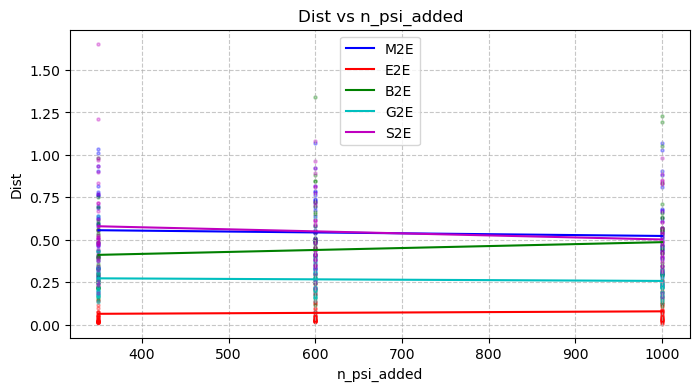


Regression Statistics:
--------------------------------------------------

M2E:
Equation: y = -0.0000x + 0.5965
R² = 0.0141
p-value = 2.2058e-01
Standard Error = 0.0000

E2E:
Equation: y = -0.0000x + 0.0871
R² = 0.0118
p-value = 2.6310e-01
Standard Error = 0.0000

B2E:
Equation: y = -0.0000x + 0.4662
R² = 0.0015
p-value = 6.8598e-01
Standard Error = 0.0000

G2E:
Equation: y = -0.0000x + 0.3030
R² = 0.0294
p-value = 7.5836e-02
Standard Error = 0.0000

S2E:
Equation: y = -0.0000x + 0.5982
R² = 0.0104
p-value = 2.9406e-01
Standard Error = 0.0000


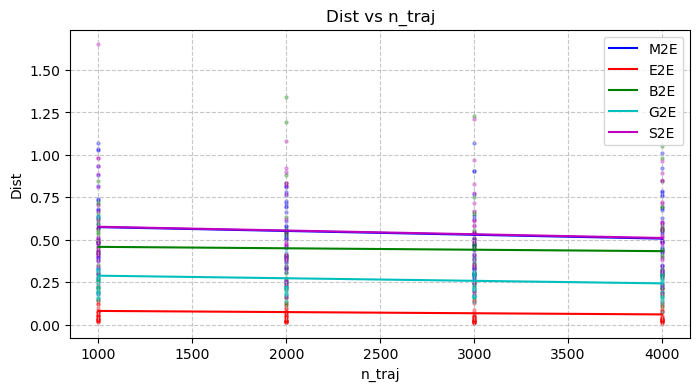


Regression Statistics:
--------------------------------------------------

M2E:
Equation: y = -0.1934x + 0.6948
R² = 0.0221
p-value = 1.2481e-01
Standard Error = 0.1250

E2E:
Equation: y = -0.0332x + 0.0966
R² = 0.0059
p-value = 4.2844e-01
Standard Error = 0.0418

B2E:
Equation: y = -0.2123x + 0.6149
R² = 0.0209
p-value = 1.3582e-01
Standard Error = 0.1413

G2E:
Equation: y = -0.2389x + 0.4563
R² = 0.1565
p-value = 2.2572e-05
Standard Error = 0.0539

S2E:
Equation: y = -0.3002x + 0.7832
R² = 0.0410
p-value = 3.5638e-02
Standard Error = 0.1410


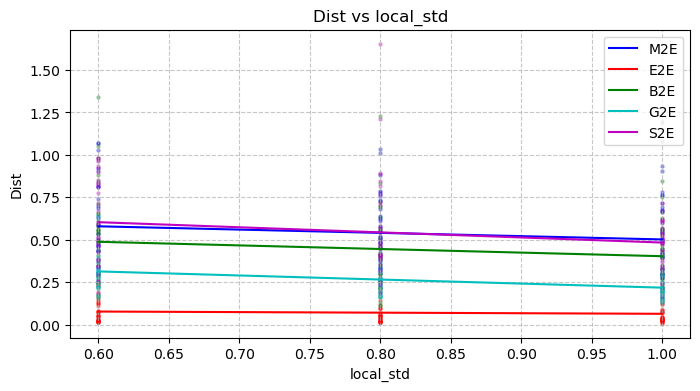


Regression Statistics:
--------------------------------------------------

M2E:
Equation: y = 0.0016x + 0.4859
R² = 0.0192
p-value = 1.5232e-01
Standard Error = 0.0011

E2E:
Equation: y = -0.0000x + 0.0712
R² = 0.0001
p-value = 9.2388e-01
Standard Error = 0.0004

B2E:
Equation: y = 0.0031x + 0.3433
R² = 0.0532
p-value = 1.6308e-02
Standard Error = 0.0013

G2E:
Equation: y = 0.0014x + 0.2181
R² = 0.0674
p-value = 6.6416e-03
Standard Error = 0.0005

S2E:
Equation: y = 0.0069x + 0.3156
R² = 0.2614
p-value = 1.5697e-08
Standard Error = 0.0011


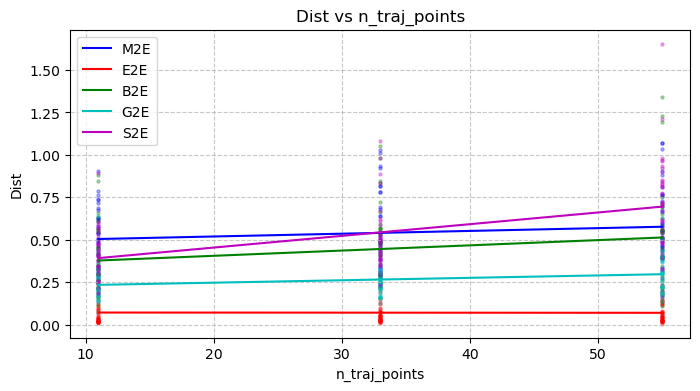

In [13]:
#['n_psi_added', 'n_traj', 'local_std', 'n_traj_points', 'Dist', 'Cos_Dist', 'Dist_rho', 'Norm_glob', 'Norm_loc', 'Norm_imp', 'Pinv_error', 'Sum_weights', 'Sum_squared_weights', 'Elapsed_time', 'Process_mem']

test_names = ["M2E", "E2E", "B2E", "G2E", "S2E"]
y_column = "Dist"
table_name = "results"
params = ["n_psi_added", "n_traj", "local_std", "n_traj_points"]

z_column = None#"n_traj_points"
focus = None#[33, 55]

for x_column in params:
    plot_database_columns(test_names, x_column, y_column, table_name, z_column=z_column, focus=focus)

[[0.39592922 0.5400665  0.4996177  0.59955405 0.49571918]
 [0.24036785 0.0699949  0.18312438 0.34416022 0.5009078 ]
 [0.6216775  0.44503239 0.41935968 0.52563758 0.47719339]
 [0.40304594 0.26516464 0.34384856 0.15726661 0.41827699]
 [0.61379452 0.54303893 0.58783004 0.60494357 0.52486213]]


<Figure size 1000x600 with 0 Axes>

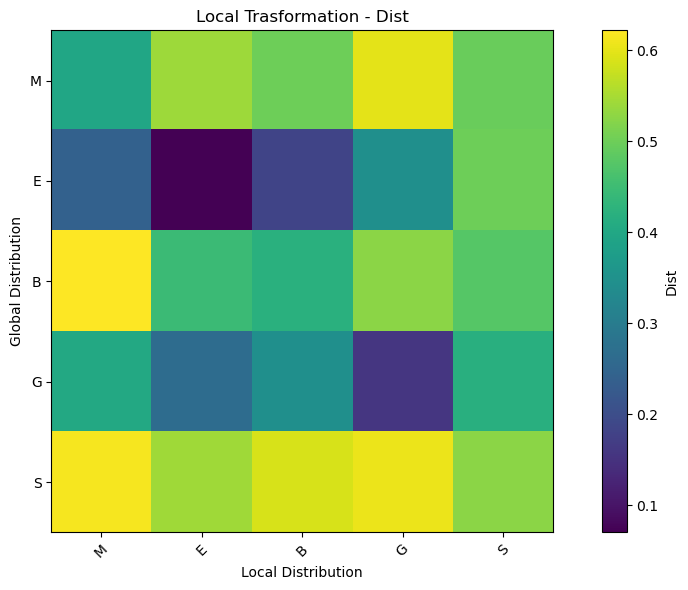

In [19]:
tests_acronym = ["M", "E", "B", "G", "S"]
value = "Dist"


plot_tests_vs(tests_acromym=tests_acronym, value=value, focus_dict = None, table_name="results")